# Deep Learning with fMRI

### Import packages and data

In [3]:
import h5py
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
filepath = 'data/pca_data_N400T8.mat'

variables = {}
f = h5py.File(filepath)
for k, v in f.items():
    variables[k] = np.array(v)
    
COEFFS = variables['COEFFS']
SCORES = variables['SCORES']
FCmeans = loadmat('data/means.mat')['means']

del variables

/Users/michael/anaconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:8: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  


### Reconstruct matrix with custom # of principle components with SCORES * COEFFS'

In [49]:
num_comps = 80 # Choose number of components to include

In [50]:
SCORES_temp, COEFFS_temp = SCORES, COEFFS
SCORES_temp[num_comps:], COEFFS_temp[num_comps:] = 0, 0

In [51]:
orig_mat = COEFFS.dot(SCORES) # use all PCA components to reconstruct matrix
orig_mat += FCmeans.transpose() # plug mean back in 
orig_mat.shape #400 subjects, 8 subjects, test, retest. order: 3200/3200 test retest, 400 subject split, 8 tasks within subject

(6400, 69751)

In [52]:
num_tasks = 8
num_subjects = int(orig_mat.shape[0] / (2 * num_tasks))
num_fcs = orig_mat.shape[0]

### Visualize a full connectome

In [53]:
def utri2mat(utri):
    n = int(-1 + np.sqrt(1 + 8*len(utri))) // 2
    iu1 = np.triu_indices(n)
    ret = np.empty((n, n))
    ret[iu1] = utri
    ret.T[iu1] = utri
    return ret

In [54]:
fc_example = utri2mat(orig_mat[0])

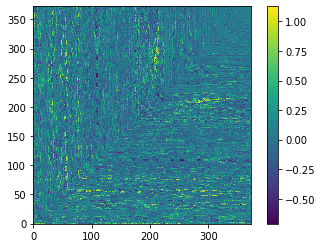

In [55]:
plt.imshow(fc_example,origin='lower')
plt.colorbar()
plt.show()

### Label each index based on subject and task

In [71]:
subj_vec = np.repeat(np.arange(1,401),2*num_tasks)
task_vec = ['Rest', 'WM', 'Emotional', 'Motor', 'Relational', 'Gambling', 'Empty', 'Filler']
labels = torch.tensor(list(np.arange(8))*(2*num_subjects), dtype=torch.long)
label_dict = dict(zip(np.arange(8), task_vec))

### Example functional connectome

## Deep Learning

In [72]:
import torch
from torch import nn, optim
from torch.utils import data

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
if use_cuda:
    cudnn.benchmark = True

### Train, Validation, Test split

In [73]:
indices = np.random.permutation(num_fcs)

In [74]:
train_idx = indices[:int(0.6*num_fcs)]
val_idx = indices[:int(0.2*num_fcs)]
test_idx = indices[:int(0.2*num_fcs)]

### Data Normalization for training and validation

In [75]:
mean = orig_mat[train_idx,:].mean()
std = orig_mat[train_idx,:].std()
orig_mat[train_idx,:] = (orig_mat[train_idx,:] - mean) / std
orig_mat[val_idx,:] = (orig_mat[val_idx,:] - mean) / std
orig_mat = torch.Tensor(orig_mat) 

In [76]:
train_data = []
for i in range(len(train_idx)):
    train_data.append([orig_mat[i], labels[i]])
    
val_data = []
for i in range(len(val_idx)):
    val_data.append([orig_mat[i], labels[i]])

test_data = []
for i in range(len(test_idx)):
    test_data.append([orig_mat[i], labels[i]])

In [77]:
trainloader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=100)
val_loader = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=100)

## Build convolutional neural network (CNN) architecture

In [78]:
input_size = orig_mat.shape[1] # number of columns
hidden_sizes = [1024, 64]
output_size = num_tasks
max_epochs = 10



In [103]:
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.BatchNorm1d(hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Dropout(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.BatchNorm1d(hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size))

In [105]:
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=0.1)
print(model)

Sequential(
  (0): Linear(in_features=69751, out_features=1024, bias=True)
  (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=1024, out_features=64, bias=True)
  (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Linear(in_features=64, out_features=8, bias=True)
)


### Training the Neural Network

In [ ]:

history = {}
history['loss'] = []
history['val_loss'] = []
history['acc'] = []
history['val_acc'] = []


# Loop over epochs


for epoch in range(max_epochs):
    # Training
    model.train()
    train_loss         = 0.0
    num_train_correct  = 0
    num_train_examples = 0
    for local_batch, local_labels in trainloader:
        # Transfer to GPU
        if use_cuda:
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        
        

        opt.zero_grad()
        output = model(local_batch)
        loss = loss_fn(output, local_labels)
        loss.backward()
        opt.step()
        
        train_loss += loss.data.item() * local_batch.size(0)
        num_train_correct  += (torch.max(output, 1)[1] == local_labels).sum().item()
        num_train_examples += local_batch.shape[0]
        
        train_acc = num_train_correct / num_train_examples
        train_loss  = train_loss / len(trainloader.dataset)
        
    # Validation
    model.eval()
    val_loss       = 0.0
    num_val_correct  = 0
    num_val_examples = 0
    with torch.set_grad_enabled(False):
        for local_batch, local_labels in val_loader:
            # Transfer to GPU
            if use_cuda:
                local_batch, local_labels = local_batch.to(device), local_labels.to(device)
            output = model(local_batch)
            loss = loss_fn(output, local_labels)
            
            val_loss += loss.data.item() * local_batch.size(0)
            num_val_correct  += (torch.max(output, 1)[1] == local_labels).sum().item()
            num_val_examples += local_batch.shape[0]
            
        val_acc  = num_val_correct / num_val_examples
        val_loss = val_loss / len(val_loader.dataset)
        
    print(f'Epoch {epoch+1}/{max_epochs}, train loss: {train_loss:5.4f}, train acc: {train_acc:5.3f}, val loss: {val_loss:5.3f}, val acc: {val_acc:5.3f}')
    
    
    history['loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['acc'].append(train_acc)
    history['val_acc'].append(val_acc)


Epoch 1/10, train loss: 0.0216, train acc: 0.114, val loss: 2.112, val acc: 0.127
Epoch 2/10, train loss: 0.0220, train acc: 0.111, val loss: 2.087, val acc: 0.134
Epoch 3/10, train loss: 0.0220, train acc: 0.130, val loss: 2.084, val acc: 0.129
Epoch 4/10, train loss: 0.0215, train acc: 0.138, val loss: 2.084, val acc: 0.136
Epoch 5/10, train loss: 0.0213, train acc: 0.127, val loss: 2.082, val acc: 0.123
Epoch 6/10, train loss: 0.0215, train acc: 0.131, val loss: 2.081, val acc: 0.126
Epoch 7/10, train loss: 0.0218, train acc: 0.128, val loss: 2.078, val acc: 0.141
